## 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np 
import os
from tqdm import tqdm
from glob import glob

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## 데이터 불러오기

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

In [3]:
train.head()

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,index,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
submission.head()

,index,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


## 학습용 데이터셋 분리하기

In [6]:
train_index = train["index"]
train_data = train.iloc[:, 2:]
train_label = train["label"]

test_index = test["index"]
test_data = test.iloc[:, 1:]

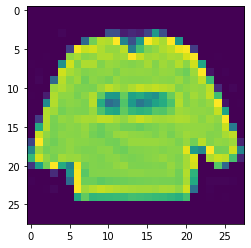

In [7]:
plt.imshow(tf.reshape(train_data.iloc[0, :], shape = [28, 28, 1]))

In [8]:
pd.value_counts(train_label)

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

## 데이터 전처리

In [9]:
train_data = tf.convert_to_tensor(train_data)
train_data = tf.reshape(train_data, shape = [-1, 28, 28, 1])

test_data = tf.convert_to_tensor(test_data)
test_data = tf.reshape(test_data, shape = [-1, 28, 28, 1])

In [10]:
train_data.shape, test_data.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [11]:
train_label = tf.convert_to_tensor(train_label)

In [12]:
train_label

<tf.Tensor: shape=(60000,), dtype=int64, numpy=array([2, 9, 6, ..., 8, 8, 7])>

## 모델 학습 준비

In [13]:
num_epochs = 15
batch_size = 64

learning_rate = 0.0005

dropout_rate = 0.3

input_shape = (28, 28, 1)
num_classes = 10

## 모델링

In [14]:
inputs = layers.Input(input_shape)

con1 = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
act1 = layers.Activation('relu')(con1)
con2 = layers.Conv2D(64, (3, 3), padding='SAME')(act1)
act2 = layers.Activation('relu')(con2)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(act2)
drop1 = layers.Dropout(dropout_rate)(pool1)

con3 = layers.Conv2D(64, (3, 3), padding='SAME')(drop1)
act3 = layers.Activation('relu')(con3)
con4 = layers.Conv2D(128, (3, 3), padding='SAME')(act3)
act4 = layers.Activation('relu')(con4)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(act4)
drop2 = layers.Dropout(dropout_rate)(pool2)

flat = layers.Flatten()(drop2)
den1 = layers.Dense(512)(flat)
act5 = layers.Activation('relu')(den1)
drop3 = layers.Dropout(dropout_rate)(act5)
den2 = layers.Dense(num_classes)(drop3)
output = layers.Activation('softmax')(den2)

model = tf.keras.Model(inputs=inputs, outputs=output, name='Basic_CNN')

In [15]:
model.summary()

Model: "Basic_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0 

## 모델 학습하기

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [17]:
history = model.fit(x = train_data, y = train_label,
                    epochs = num_epochs,
                   batch_size = batch_size,
                   validation_split = 0.2,
                   shuffle = True)

Epoch 1/15
750/750 [==============================] - 4s 5ms/step - loss: 0.8931 - accuracy: 0.7897 - val_loss: 0.3496 - val_accuracy: 0.8687
Epoch 2/15
750/750 [==============================] - 3s 4ms/step - loss: 0.3540 - accuracy: 0.8693 - val_loss: 0.2860 - val_accuracy: 0.8921
Epoch 3/15
750/750 [==============================] - 3s 4ms/step - loss: 0.3037 - accuracy: 0.8882 - val_loss: 0.2611 - val_accuracy: 0.9038
Epoch 4/15
750/750 [==============================] - 3s 4ms/step - loss: 0.2738 - accuracy: 0.8983 - val_loss: 0.2466 - val_accuracy: 0.9124
Epoch 5/15
750/750 [==============================] - 3s 4ms/step - loss: 0.2465 - accuracy: 0.9106 - val_loss: 0.2369 - val_accuracy: 0.9145
Epoch 6/15
750/750 [==============================] - 3s 4ms/step - loss: 0.2300 - accuracy: 0.9147 - val_loss: 0.2139 - val_accuracy: 0.9237
Epoch 7/15
750/750 [==============================] - 3s 4ms/step - loss: 0.2148 - accuracy: 0.9203 - val_loss: 0.2198 - val_accuracy: 0.9200
Epoch 

## 추론하기

In [18]:
result = np.argmax(model.predict(test_data), axis = 1)

In [19]:
submission["label"] = result

In [20]:
submission

,index,label
0,0,0
1,1,1
2,2,2
3,3,2
4,4,3
...,...,...
9995,9995,0
9996,9996,6
9997,9997,8
9998,9998,8


## 제출

In [21]:
submission.to_csv("baseline.csv", index = False)